In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pickle
# Directory and file paths
train_dir = 'train_set/images'
val_dir = 'val_set/images'
train_ann_file = 'train_annotation.csv'
val_ann_file = 'val_annotation.csv'

# Parameters
input_shape = (227, 227, 3)  # Specify input image shape
batch_size = 24
num_emotions = 8

# Function to one-hot encode emotion labels
def one_hot_encode(number, num_classes=num_emotions):
    one_hot_vector = np.zeros(num_classes)
    one_hot_vector[number] = 1
    return one_hot_vector

# Training parameters
# epoch_steps = 30000 // batch_size
epoch_steps=30
val_steps = 30
epoch = 10


In [2]:
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [3]:
# Define CCC function
def ccc(y_true, y_pred):
    y_true_mean = tf.reduce_mean(y_true, axis=0)
    y_pred_mean = tf.reduce_mean(y_pred, axis=0)
    
    covariance = tf.reduce_mean((y_true - y_true_mean) * (y_pred - y_pred_mean))
    true_var = tf.reduce_mean((y_true - y_true_mean) ** 2)
    pred_var = tf.reduce_mean((y_pred - y_pred_mean) ** 2)
    
    ccc_value = 2 * covariance / (true_var + pred_var + tf.square(y_true_mean - y_pred_mean))
    
    return 1 - ccc_value

In [4]:
# Function to generate augmented data for minority class images
def data_generator(dir_path, ann_file, batch_size, input_shape, augment=False):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    minority_classes=[4,5,7]
    anno = pd.read_csv(ann_file)
    while True:
        batch_paths = np.random.choice(anno['filename'], size=batch_size)
        batch_input, batch_output_valence, batch_output_arousal, batch_output_emotion = [], [], [], []

        for input_path in batch_paths:
            img_path = os.path.join(dir_path, str(input_path)+'.jpg')
            img = load_img(img_path, target_size=input_shape)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Reshape to add batch dimension
            img_array = next(datagen.flow(img_array, batch_size=1))[0]
            row = anno[anno["filename"] == input_path]
            if row.empty:
                print(f"Warning: No annotation found for {input_path}")
                continue
            
            batch_input.append(img_array)
            batch_output_valence.append(row["Valance"].values[0])
            batch_output_arousal.append(row["Arousal"].values[0])
            batch_output_emotion.append(one_hot_encode(row["Expression"].values[0]))

        batch_input = np.array(batch_input)
        batch_output_valence = np.array(batch_output_valence)
        batch_output_arousal = np.array(batch_output_arousal)
        batch_output_emotion = np.array(batch_output_emotion)

        yield batch_input, {"valence": batch_output_valence, "arousal": batch_output_arousal, "emotion": batch_output_emotion}

In [5]:
#Downsampling majority class and upsampling minority class
def data_generator_down_up(dir_path, ann_file, batch_size, input_shape, augment=False):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    minority_classes = [4, 5, 7]
    ann_file = pd.read_csv(ann_file)
    majority_classes = ann_file[~ann_file["Expression"].isin(minority_classes)]
    minority_classes = ann_file[ann_file["Expression"].isin(minority_classes)]

    while True:
        batch_input, batch_output_valence, batch_output_arousal, batch_output_emotion = [], [], [], []

        majority_batch_paths = np.random.choice(majority_classes['filename'], size=batch_size // 2)
        minority_batch_paths = np.random.choice(minority_classes['filename'], size=batch_size // 2)
        # Determine the number of samples to take from minority and majority classes
        # minority_size = int(batch_size * 0.50)
        # majority_size = batch_size - minority_size
        
        # # Randomly select samples from the minority and majority annotations
        # minority_batch_paths = minority_classes.sample(n=minority_size, replace=True)['filename']
        # majority_batch_paths = majority_classes.sample(n=majority_size, replace=True)['filename']
        
        for input_path in np.concatenate((majority_batch_paths, minority_batch_paths)):
            img_path = os.path.join(dir_path, str(input_path)+'.jpg')
            img = load_img(img_path, target_size=input_shape)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Reshape to add batch dimension
            
            row = ann_file[ann_file["filename"] == input_path]
            if row.empty:
                print(f"Warning: No annotation found for {input_path}")
                continue
            
            # Check if the image belongs to a minority class
            emotion_class = row["Expression"].values[0]
            if augment and emotion_class in minority_classes:
                # Apply data augmentation
                for _ in range(3):  # Generate 3 augmented images
                    augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
                    batch_input.append(augmented_img)  # Remove batch dimension
                    batch_output_valence.append(row["Valance"].values[0])
                    batch_output_arousal.append(row["Arousal"].values[0])
                    batch_output_emotion.append(one_hot_encode(row["Expression"].values[0]))
                    
            else:
                # No augmentation for majority classes
                batch_input.append(img_array[0])
                batch_output_valence.append(row["Valance"].values[0])
                batch_output_arousal.append(row["Arousal"].values[0])
                batch_output_emotion.append(one_hot_encode(row["Expression"].values[0]))

        batch_input = np.array(batch_input)
        batch_output_valence = np.array(batch_output_valence)
        batch_output_arousal = np.array(batch_output_arousal)
        batch_output_emotion = np.array(batch_output_emotion)

        yield batch_input, {"valence": batch_output_valence, "arousal": batch_output_arousal, "emotion": batch_output_emotion}

In [6]:
# Define the data generator function with augmentation and equal class distribution
def data_generator_equal(dir_path, ann_file, batch_size, input_shape, augment=False, num_classes=8, augment_count=1):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    anno = pd.read_csv(ann_file)
    class_counts = anno['Expression'].value_counts().to_dict()

    while True:
        # Initialize empty lists for the batch
        batch_input, batch_output_valence, batch_output_arousal, batch_output_emotion = [], [], [], []
        
        # Determine the number of samples per class
        samples_per_class = batch_size // num_classes
        
        for emotion_class in range(num_classes):
            class_anno = anno[anno["Expression"] == emotion_class]
            selected_paths = class_anno.sample(n=samples_per_class, replace=True)['filename']
            
            for input_path in selected_paths:
                img_path = os.path.join(dir_path, str(input_path)+'.jpg')
                try:
                    img = load_img(img_path, target_size=input_shape)
                    img_array = img_to_array(img)
                    img_array = np.expand_dims(img_array, axis=0)  # Reshape to add batch dimension
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue
                
                row = class_anno[class_anno["filename"] == input_path]
                if row.empty:
                    print(f"Warning: No annotation found for {input_path}")
                    continue
                
                # Check if the image should be augmented
                if augment:
                    # Apply data augmentation
                    for _ in range(augment_count):  # Generate augment_count augmented images
                        augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
                        batch_input.append(augmented_img)  # Remove batch dimension
                        batch_output_valence.append(row["Valance"].values[0])
                        batch_output_arousal.append(row["Arousal"].values[0])
                        batch_output_emotion.append(one_hot_encode(row["Expression"].values[0], num_classes=num_classes))
                else:
                    # No augmentation
                    batch_input.append(img_array[0])
                    batch_output_valence.append(row["Valance"].values[0])
                    batch_output_arousal.append(row["Arousal"].values[0])
                    batch_output_emotion.append(one_hot_encode(row["Expression"].values[0], num_classes=num_classes))

        # Convert lists to numpy arrays
        try:
            batch_input = np.array(batch_input)
            batch_output_valence = np.array(batch_output_valence)
            batch_output_arousal = np.array(batch_output_arousal)
            batch_output_emotion = np.array(batch_output_emotion)
        except Exception as e:
            print(f"Error converting batch to numpy arrays: {e}")
            continue
        yield batch_input, {"valence": batch_output_valence, "arousal": batch_output_arousal, "emotion": batch_output_emotion}

Model Definitioin: AlexNet

In [7]:
# Model definition
input_layer = Input(shape=input_shape)
x = Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Flatten()(x)
x = Dense(9216, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)


#common part for all the multitask models
# Valence task-specific layers
dense_valence = Dense(64, activation='relu')(x)
output_valence = Dense(1, activation='sigmoid', name='valence')(dense_valence)

# Arousal task-specific layers
dense_arousal = Dense(64, activation='relu')(x)
output_arousal = Dense(1, activation='sigmoid', name='arousal')(dense_arousal)

# Emotion task-specific layers
dense_emotion = Dense(64, activation='relu')(x)
output_emotion = Dense(num_emotions, activation='softmax', name='emotion')(dense_emotion)

In [8]:
# # Compile the model
# modelOri = Model(inputs=input_layer, outputs=[output_valence, output_arousal, output_emotion])
# modelOri.compile(optimizer=Adam(),
#               loss={'valence': 'mse', 'arousal': 'mse', 'emotion': 'categorical_crossentropy'},
#               metrics={'valence': ['mae','accuracy',ccc,rmse], 'arousal': ['mae','accuracy', ccc, rmse], 'emotion': ['accuracy']})

# # Training and validation data generators
# train_genOri = data_generator(train_dir, train_ann_file, batch_size, input_shape)
# val_genOri = data_generator(val_dir, val_ann_file, batch_size, input_shape)

# # Callbacks
# callbacks = [
#     EarlyStopping(monitor='valence_loss', patience=10, restore_best_weights=True),
#     ModelCheckpoint('best_modelOri.h5', save_best_only=True, monitor='valence_loss'),
#     ReduceLROnPlateau(monitor='valence_loss', factor=0.2, patience=5, min_lr=1e-6)
# ]

# # Train the model
# historyOri = modelOri.fit(train_genOri, steps_per_epoch=epoch_steps, epochs=epoch, callbacks=callbacks)

In [9]:
# with open('plots/AlexNethistoryOri.pkl', 'wb') as file:
#     pickle.dump(historyOri.history, file)

In [10]:
# # Collect true labels and predictions
# y_true_valence, y_pred_valence = [], []
# y_true_arousal, y_pred_arousal = [], []
# y_true_emotion, y_pred_emotion = [], []

# resultallOri = modelOri.evaluate(val_genOri, steps=val_steps)

In [11]:
# # Convert the results to a DataFrame
# df_results = pd.DataFrame([resultallOri], columns=modelOri.metrics_names)

# # Save the DataFrame to a CSV file
# df_results.to_csv("plots/AlexNetOri_results.csv", index=False)

In [12]:
# for _ in range(val_steps):
#     x_val, y_val = next(val_genOri)
#     y_pred = modelOri.predict(x_val)
    
#     y_true_valence.extend(y_val['valence'])
#     y_pred_valence.extend(y_pred[0].squeeze())  # Squeeze to match shape
#     y_true_arousal.extend(y_val['arousal'])
#     y_pred_arousal.extend(y_pred[1].squeeze())  # Squeeze to match shape
#     y_true_emotion.extend(y_val['emotion'])
#     y_pred_emotion.extend(y_pred[2])

# # Convert lists to arrays
# y_true_valence = np.array(y_true_valence)
# y_pred_valence = np.array(y_pred_valence)
# y_true_arousal = np.array(y_true_arousal)
# y_pred_arousal = np.array(y_pred_arousal)
# y_true_emotion = np.argmax(np.array(y_true_emotion), axis=1)
# y_pred_emotion = np.argmax(np.array(y_pred_emotion), axis=1)

# # Calculate Precision, Recall, and F1-Score for emotion
# true_positives = np.sum((y_pred_emotion == y_true_emotion) & (y_true_emotion == 1))
# predicted_positives = np.sum(y_pred_emotion == 1)
# actual_positives = np.sum(y_true_emotion == 1)

# precision = true_positives / predicted_positives if predicted_positives > 0 else 0
# recall = true_positives / actual_positives if actual_positives > 0 else 0
# f1_score = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)


# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1_score:.4f}")
# evaluation_metrics = {
#     "Emotion precision": round(precision, 4),
#     "Emotion recall": round(recall, 4),
#     "Emotion F1-Score": round(f1_score, 4),
# }

# df_results = pd.DataFrame([evaluation_metrics])

# # Save the DataFrame to a CSV file
# df_results.to_csv("plots/csv_files_results/PRF_emotion_AlexNetOri.csv", index=False)


In [13]:
# # Plot training and validation loss
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(historyOri.history['valence_loss'], label='Valence Loss')
# plt.plot(historyOri.history['arousal_loss'], label='Arousal Loss')
# plt.plot(historyOri.history['emotion_loss'], label='Emotion Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plot training and validation accuracy
# plt.subplot(1, 2, 2)
# plt.plot(historyOri.history['valence_accuracy'], label='Valence Accuracy')
# plt.plot(historyOri.history['arousal_accuracy'], label='Arousal Accuracy')
# plt.plot(historyOri.history['emotion_accuracy'], label='Emotion Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.savefig("plots/AlexNetOritrainingloss_acc.pdf",bbox_inches='tight')
# plt.show()

In [14]:
# modelCW = Model(inputs=input_layer, outputs=[output_valence, output_arousal, output_emotion])
# # Calculate class weights
# total_samples = 134415 + 74874 + 25459 + 24882 + 14090 + 6378 + 3803 + 3750
# class_weights = {
#     "valence": 1.0,
#     "arousal": 1.0,
#     "emotion": {
#         0: total_samples / 134415,  # Happy
#         1: total_samples / 74874,   # Neutral
#         2: total_samples / 25459,   # Sad
#         3: total_samples / 24882,   # Anger
#         4: total_samples / 14090,   # Surprise
#         5: total_samples / 6378,    # Fear
#         6: total_samples / 3803,    # Disgust
#         7: total_samples / 3750     # Contempt
#     }
# }

# modelCW.compile(optimizer=Adam(),
#               loss={'valence': 'mse', 'arousal': 'mse', 'emotion': 'categorical_crossentropy'},
#               metrics={'valence': ['mae','accuracy',ccc, rmse], 'arousal': ['mae','accuracy', ccc, rmse], 'emotion': ['accuracy']},
#               loss_weights=class_weights)  # Pass class weights to the loss_weights parameter

# # Training and validation data generators
# train_genCW = data_generator(train_dir, train_ann_file, batch_size, input_shape)
# val_genCW = data_generator(val_dir, val_ann_file, batch_size, input_shape)


# # Callbacks
# callbacks = [
#     EarlyStopping(monitor='valence_loss', patience=10, restore_best_weights=True),
#     ModelCheckpoint('best_modelAlexNetWC.h5', save_best_only=True, monitor='valence_loss'),
#     ReduceLROnPlateau(monitor='valence_loss', factor=0.2, patience=5, min_lr=1e-6)
# ]

# # Train the model
# historyCW = modelCW.fit(train_genCW, steps_per_epoch=epoch_steps, epochs=epoch, callbacks=callbacks)

In [15]:
# with open('plots/AlexNethistoryCW.pkl', 'wb') as file:
#     pickle.dump(historyCW.history, file)

In [16]:
# # Collect true labels and predictions
# y_true_valence, y_pred_valence = [], []
# y_true_arousal, y_pred_arousal = [], []
# y_true_emotion, y_pred_emotion = [], []

# resultallCW = modelCW.evaluate(val_genCW, steps=val_steps)

In [17]:
# # Convert the results to a DataFrame
# df_results = pd.DataFrame([resultallCW], columns=modelCW.metrics_names)

# # Save the DataFrame to a CSV file
# df_results.to_csv("plots/csv_files_results/AlexNetCW_results.csv", index=False)

In [18]:
# for _ in range(val_steps):
#     x_val, y_val = next(val_genCW)
#     y_pred = modelCW.predict(x_val)
    
#     y_true_valence.extend(y_val['valence'])
#     y_pred_valence.extend(y_pred[0].squeeze())  # Squeeze to match shape
#     y_true_arousal.extend(y_val['arousal'])
#     y_pred_arousal.extend(y_pred[1].squeeze())  # Squeeze to match shape
#     y_true_emotion.extend(y_val['emotion'])
#     y_pred_emotion.extend(y_pred[2])

# # Convert lists to arrays
# y_true_valence = np.array(y_true_valence)
# y_pred_valence = np.array(y_pred_valence)
# y_true_arousal = np.array(y_true_arousal)
# y_pred_arousal = np.array(y_pred_arousal)
# y_true_emotion = np.argmax(np.array(y_true_emotion), axis=1)
# y_pred_emotion = np.argmax(np.array(y_pred_emotion), axis=1)

# # Calculate Precision, Recall, and F1-Score for emotion
# true_positives = np.sum((y_pred_emotion == y_true_emotion) & (y_true_emotion == 1))
# predicted_positives = np.sum(y_pred_emotion == 1)
# actual_positives = np.sum(y_true_emotion == 1)

# precision = true_positives / predicted_positives if predicted_positives > 0 else 0
# recall = true_positives / actual_positives if actual_positives > 0 else 0
# f1_score = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)


# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1_score:.4f}")
# evaluation_metrics = {
#     "Emotion precision": round(precision, 4),
#     "Emotion recall": round(recall, 4),
#     "Emotion F1-Score": round(f1_score, 4),
# }

# df_results = pd.DataFrame([evaluation_metrics])

# # Save the DataFrame to a CSV file
# df_results.to_csv("plots/csv_files_results/PRF_emotion_AlexNetCW.csv", index=False)


In [19]:
# # Plot training and validation loss
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(historyCW.history['valence_loss'], label='Valence Loss')
# plt.plot(historyCW.history['arousal_loss'], label='Arousal Loss')
# plt.plot(historyCW.history['emotion_loss'], label='Emotion Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plot training and validation accuracy
# plt.subplot(1, 2, 2)
# plt.plot(historyCW.history['valence_accuracy'], label='Valence Accuracy')
# plt.plot(historyCW.history['arousal_accuracy'], label='Arousal Accuracy')
# plt.plot(historyCW.history['emotion_accuracy'], label='Emotion Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.savefig("plots/AlexNetCWtrainingloss_acc.pdf",bbox_inches='tight')
# plt.show()

In [20]:
# Compile the model
modelUD = Model(inputs=input_layer, outputs=[output_valence, output_arousal, output_emotion])
modelUD.compile(optimizer=Adam(),
              loss={'valence': 'mse', 'arousal': 'mse', 'emotion': 'categorical_crossentropy'},
              metrics={'valence': ['mae','accuracy',ccc, rmse], 'arousal': ['mae','accuracy', ccc, rmse], 'emotion': ['accuracy']})

# Training and validation data generators
train_genUD = data_generator_down_up(train_dir, train_ann_file, batch_size, input_shape, augment=True)
val_genUD = data_generator(val_dir, val_ann_file, batch_size, input_shape)

# Callbacks
callbacks = [
    EarlyStopping(monitor='valence_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_modelOri.h5', save_best_only=True, monitor='valence_loss'),
    ReduceLROnPlateau(monitor='valence_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Train the model
historyUD = modelUD.fit(train_genUD, steps_per_epoch=epoch_steps, epochs=epoch, callbacks=callbacks)

Epoch 1/10
30/30 [==============================] - 11s 214ms/step - loss: 77.0597 - valence_loss: 0.4300 - arousal_loss: 0.1651 - emotion_loss: 76.4646 - valence_mae: 0.5344 - valence_accuracy: 0.0083 - valence_ccc: 1.0029 - valence_rmse: 0.6182 - arousal_mae: 0.3364 - arousal_accuracy: 0.0111 - arousal_ccc: 0.9981 - arousal_rmse: 0.3972 - emotion_accuracy: 0.2069
Epoch 2/10
30/30 [==============================] - 6s 195ms/step - loss: 2.3065 - valence_loss: 0.2800 - arousal_loss: 0.1287 - emotion_loss: 1.8979 - valence_mae: 0.4474 - valence_accuracy: 0.0167 - valence_ccc: 1.0011 - valence_rmse: 0.5272 - arousal_mae: 0.3091 - arousal_accuracy: 0.0139 - arousal_ccc: 0.9862 - arousal_rmse: 0.3565 - emotion_accuracy: 0.2264
Epoch 3/10
30/30 [==============================] - 6s 195ms/step - loss: 2.3231 - valence_loss: 0.2710 - arousal_loss: 0.1324 - emotion_loss: 1.9197 - valence_mae: 0.4406 - valence_accuracy: 0.0083 - valence_ccc: 1.0043 - valence_rmse: 0.5181 - arousal_mae: 0.3122 -

In [21]:
with open('plots/AlexNethistoryUD.pkl', 'wb') as file:
    pickle.dump(historyUD.history, file)

In [22]:
# Collect true labels and predictions
y_true_valence, y_pred_valence = [], []
y_true_arousal, y_pred_arousal = [], []
y_true_emotion, y_pred_emotion = [], []

resultallUD = modelUD.evaluate(val_genUD, steps=val_steps)

30/30 [==============================] - 12s 389ms/step - loss: 2.6154 - valence_loss: 0.2505 - arousal_loss: 0.1507 - emotion_loss: 2.2142 - valence_mae: 0.4123 - valence_accuracy: 0.0222 - valence_ccc: 1.0000 - valence_rmse: 0.4973 - arousal_mae: 0.3281 - arousal_accuracy: 0.0208 - arousal_ccc: 0.9999 - arousal_rmse: 0.3857 - emotion_accuracy: 0.1167


In [23]:
# Convert the results to a DataFrame
df_results = pd.DataFrame([resultallUD], columns=modelUD.metrics_names)

# Save the DataFrame to a CSV file
df_results.to_csv("plots/csv_files_results/AlexNetUD_results.csv", index=False)

In [24]:
for _ in range(val_steps):
    x_val, y_val = next(val_genUD)
    y_pred = modelUD.predict(x_val)
    
    y_true_valence.extend(y_val['valence'])
    y_pred_valence.extend(y_pred[0].squeeze())  # Squeeze to match shape
    y_true_arousal.extend(y_val['arousal'])
    y_pred_arousal.extend(y_pred[1].squeeze())  # Squeeze to match shape
    y_true_emotion.extend(y_val['emotion'])
    y_pred_emotion.extend(y_pred[2])

# Convert lists to arrays
y_true_valence = np.array(y_true_valence)
y_pred_valence = np.array(y_pred_valence)
y_true_arousal = np.array(y_true_arousal)
y_pred_arousal = np.array(y_pred_arousal)
y_true_emotion = np.argmax(np.array(y_true_emotion), axis=1)
y_pred_emotion = np.argmax(np.array(y_pred_emotion), axis=1)

# Calculate Precision, Recall, and F1-Score for emotion
true_positives = np.sum((y_pred_emotion == y_true_emotion) & (y_true_emotion == 1))
predicted_positives = np.sum(y_pred_emotion == 1)
actual_positives = np.sum(y_true_emotion == 1)

precision = true_positives / predicted_positives if predicted_positives > 0 else 0
recall = true_positives / actual_positives if actual_positives > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
evaluation_metrics = {
    "Emotion precision": round(precision, 4),
    "Emotion recall": round(recall, 4),
    "Emotion F1-Score": round(f1_score, 4),
}

df_results = pd.DataFrame([evaluation_metrics])

# Save the DataFrame to a CSV file
df_results.to_csv("plots/csv_files_results/PRF_emotion_AlexNetUD.csv", index=False)


Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


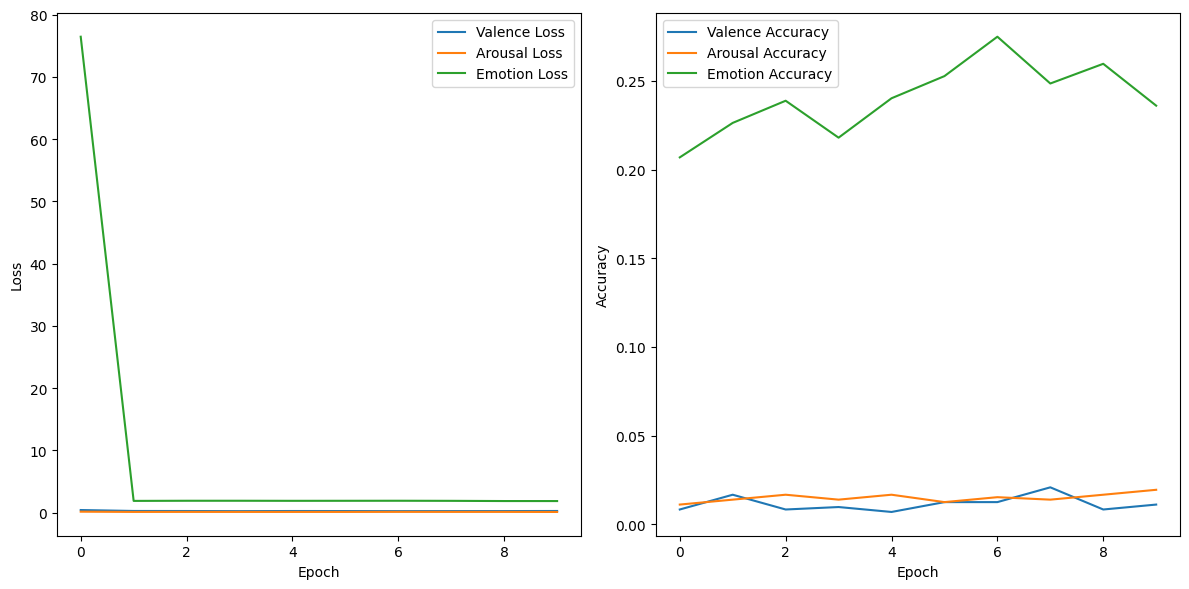

In [25]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(historyUD.history['valence_loss'], label='Valence Loss')
plt.plot(historyUD.history['arousal_loss'], label='Arousal Loss')
plt.plot(historyUD.history['emotion_loss'], label='Emotion Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(historyUD.history['valence_accuracy'], label='Valence Accuracy')
plt.plot(historyUD.history['arousal_accuracy'], label='Arousal Accuracy')
plt.plot(historyUD.history['emotion_accuracy'], label='Emotion Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("plots/AlexNetUDtrainingloss_acc.pdf",bbox_inches='tight')
plt.show()

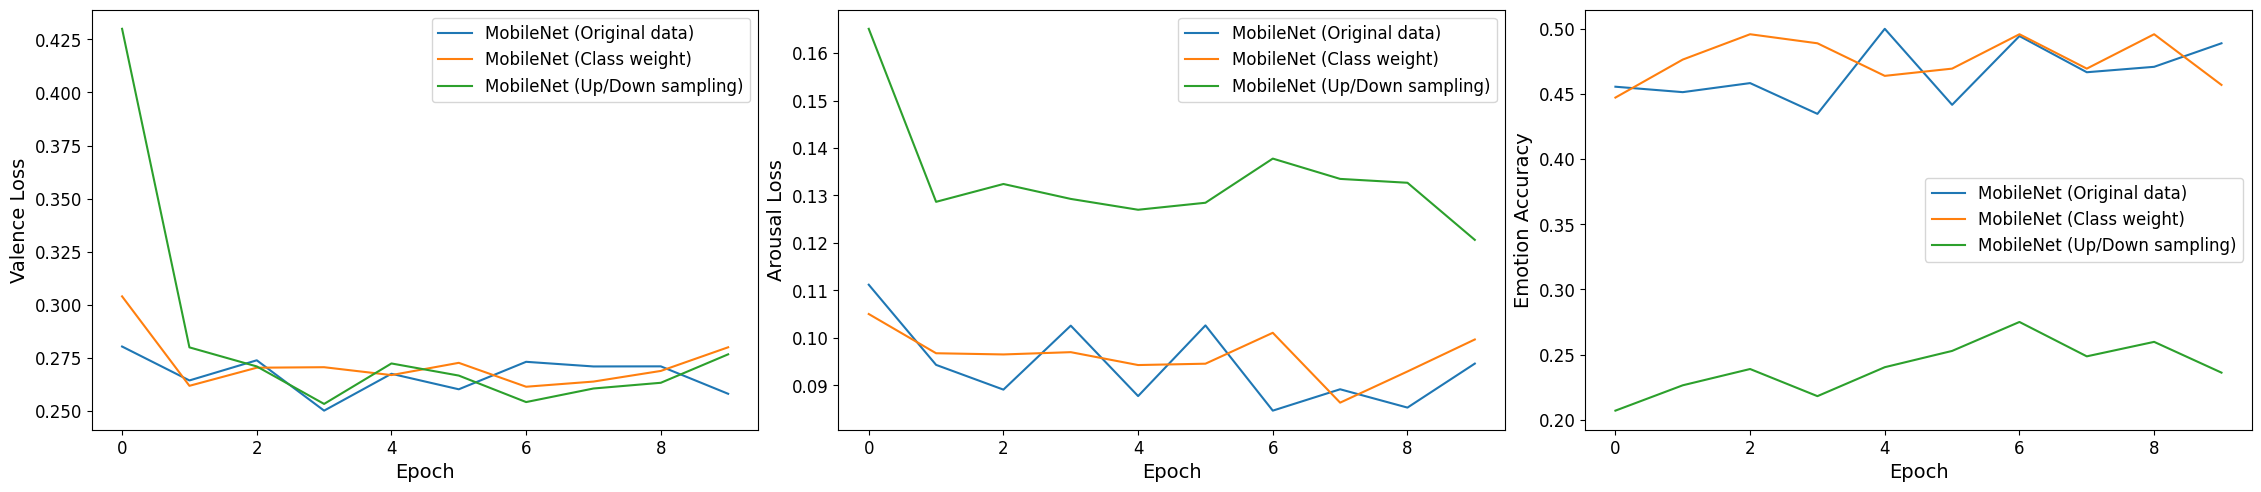

In [26]:
# Load the history objects from the files
with open('plots/AlexNethistoryOri.pkl', 'rb') as file:
    historyOri = pickle.load(file)
with open('plots/AlexNethistoryCW.pkl', 'rb') as file:
    historyCW = pickle.load(file)
with open('plots/AlexNethistoryUD.pkl', 'rb') as file:
    historyUD = pickle.load(file)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Plot valence loss
axes[0].plot(historyOri['valence_loss'], label='MobileNet (Original data)')
axes[0].plot(historyCW['valence_loss'], label='MobileNet (Class weight)')
axes[0].plot(historyUD['valence_loss'], label='MobileNet (Up/Down sampling)')
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Valence Loss', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].tick_params(axis='both', labelsize=12)
# axes[0].set_title('Valence Loss During Training', fontsize=16)

# Plot arousal loss
axes[1].plot(historyOri['arousal_loss'], label='MobileNet (Original data)')
axes[1].plot(historyCW['arousal_loss'], label='MobileNet (Class weight)')
axes[1].plot(historyUD['arousal_loss'], label='MobileNet (Up/Down sampling)')
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Arousal Loss', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].tick_params(axis='both', labelsize=12)
# axes[1].set_title('Arousal Loss During Training', fontsize=16)

# Plot emotion accuracy
axes[2].plot(historyOri['emotion_accuracy'], label='MobileNet (Original data)')
axes[2].plot(historyCW['emotion_accuracy'], label='MobileNet (Class weight)')
axes[2].plot(historyUD['emotion_accuracy'], label='MobileNet (Up/Down sampling)')
axes[2].set_xlabel('Epoch', fontsize=14)
axes[2].set_ylabel('Emotion Accuracy', fontsize=14)
axes[2].legend(fontsize=12)
axes[2].tick_params(axis='both', labelsize=12)
# axes[2].set_title('Emotion Accuracy During Training', fontsize=16)

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.12)

# Save the figure
plt.savefig("plots/AlexNet_metrics_horizontal.pdf", bbox_inches='tight')

# Show the plot
plt.show()